In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Techniques
---

<br>

### Batch normalization

Paper: https://arxiv.org/pdf/1502.03167.pdf

The idea behing batch normalization is that an ANN will learn faster and work better if the training inputs and test inputs follow the same input distribution (or alternatively, are on the same manifold). Since a multi-layer ANN can be seen as several layers on top of each other, the same principle should be true for any sub-network of the full ANN.

But in practice, changes of the parameters of the lower layers have a big impact on the inputs of the higher layers. Therefore the higher layers have to adapt to change of their input distribution constantly, and this significantly slows down training.

The idea is therefore to take the activation of layer and apply the normalization formula on each of its dimensions, $\hat{x} = \frac{x - E[x]}{\sqrt{\sigma^2[x]}}$ with:
* $E[x] = \frac{1}{m} \sum_{i=0}^m x_i$ the sample mean
* $\sigma^2[x] = \frac{1}{m-1} \sum_{i=0}^m (x_i - E[x])^2$ the sample variance

A first problem with this approach is that the mean and variance can significantly change between the minibatches, especially if there are several layers before. We therefore keep some momemtum for the mean and variance estimations (running mean and running variance, kind of gradient updates):

* $E[x] \leftarrow E[x] + \alpha (\frac{1}{m} \sum_{i=0}^m x_i - E[x])$
* $\sigma^2[x] \leftarrow \sigma^2[x] + \alpha (\frac{1}{m-1} \sum_{i=0}^m (x_i - E[x])^2 - \sigma^2[x])$

A second problem with this approach is that if we keep the values centered all the time, we lose the ability to exploit the non-linear regime of non-linearities such as sigmoids. We therefore associates two learnable parameters by dimensions $\gamma$ and $\beta$ and apply the formula:

&emsp; $\hat{x} = \gamma \frac{x - E[x]}{\sqrt{\sigma^2[x]}} + \beta$

The last problem is with the numerical stability of the division by the variance. We therefore introduce a small $\epsilon$ under the square root, and obtain the final formula:

&emsp; $\hat{x} = \gamma \frac{x - E[x]}{\sqrt{\sigma^2[x] + \epsilon}} + \beta$

Among the many **properties of Batch Normalization**, here are the most fundamental ones:

* Accelarates the training, by allowing each layer to keep the same input distribution as input (ignore covariance between dimensions)
* Make the layer insensitive to parameter scaling in lower layers $\text{BN}(Wx) = \text{BN}(\alpha W u)$
* Make the layer insensitive to explosing gradients due to scaling $\nabla_x \text{BN}(Wx) = \nabla_x \text{BN}(\alpha W u)$
* Seem to offer some kind of **regularization** because each input is handled in link with others (due to the mean and variance)

Interesting notes as well, when combining with **Linear and CNN layers**:

* Batch Normalization is better applied **before the non-linearity**
* **Linear layers do not need bias** when followed by a Batch Normalization (because it includes a bias)
* CNN requires having **weight sharing** between the activations (same as for CNN)

In [119]:
class BatchNorm1d(nn.Module):
    def __init__(self, num_features: int, epsilon: float = 1e-5, momentum: float = 0.1):
        super().__init__()
        self.num_features = num_features
        self.momentum = momentum
        self.epsilon = epsilon
        self.weight = nn.Parameter(torch.FloatTensor(num_features)) # one weight by dimension
        self.bias = nn.Parameter(torch.FloatTensor(num_features))   # one bias by dimension
        self.register_buffer('running_mean', torch.zeros(num_features)) # register_buffer makes not visible for optimizer
        self.register_buffer('running_var', torch.ones(num_features))   # register_buffer makes not visible for optimizer
        nn.init.ones_(self.weight)
        nn.init.zeros_(self.bias)
    
    def forward(self, xs):
        if self.training:
            sample_mean = torch.mean(xs)
            sample_var = torch.mean(xs**2) - sample_mean**2 # TODO - correct with m / (m-1)
            prev_running_mean = self.running_mean.detach() # detach to limit size of graph
            prev_running_var = self.running_var.detach()   # detach to limit size of graph
            self.running_mean = prev_running_mean + (1 - self.momentum) * (sample_mean - prev_running_mean)
            self.running_var = prev_running_var + (1 - self.momentum) * (sample_var - prev_running_var)
            return self.weight * (xs - self.running_mean) / torch.sqrt(self.running_var + self.epsilon) + self.bias
        else:
            prev_running_mean = self.running_mean.detach()
            prev_running_var = self.running_var.detach()
            return self.weight * (xs - prev_running_mean) / torch.sqrt(prev_running_var + self.epsilon) + self.bias


bn = BatchNorm1d(num_features=5)

bn.train()
y = bn(torch.FloatTensor([1., 2., -1, 0., 5]))
print(y)
torch.sum(y).backward()

bn.eval()
y = bn(torch.FloatTensor([5., 5., 5., 5., 5.]))
print(y)
torch.sum(y).backward()

tensor([-0.1314,  0.3739, -1.1421, -0.6367,  1.8899], grad_fn=<AddBackward0>)
tensor([1.8899, 1.8899, 1.8899, 1.8899, 1.8899], grad_fn=<AddBackward0>)


<br>

### Residual Net

Paper: https://arxiv.org/pdf/1512.03385.pdf

Addresses the **degration in training and testing error that occurs when increasing the depth** of neural networks. Stacking layers should in theory always produce a better solution, because the higher layer should in principle be able to learn the identity function.

But in practice, stacking more layers might lead to degraded training error. This is **not due to overfitting** because overfitting would only affect the testing error. This phenomenon also occurs if we have Batch Normalization layers in between. So this is not due to instability of inputs of layers. The degradation indicates that not all systems are similarly easy to optimize.

Residual networks help training by introducing **shortcut between layers**. These layers allow easier optimization of the network at increasing depth, and allow to avoid the degradation phenomena described above:

* training of networks at equal depth becomes faster in many cases
* training of networks at higher depths becomes feasible (training error keeps decreasing)
* this leads to increased performance in many case, by allowing to use deeper networks

**Why residual?** In Maths, when solving the equation $y = f(x)$ for $x$, we call residual the difference between the output of our current best solution $x_0$ with the target: $y - f(x_0)$. Similarly, when solving $y = f(x)$ for $f$, we call *residual* the difference between our best solution $f_0$ and $f$. Techniques of optimization based on optimizing the residuals are numerous and effective.

In our case, say we want to learn a function $\mathcal{H}(x)$, we could alternatively try to learn the difference between the input $x$ and desired output $\mathcal{H}(x)$, that is, we would try to learn the residual between the identity function and the target function.

So instead of learning $\mathcal{H}(x)$, we try to learn $\mathcal{F}(x) = \Delta(x) = \mathcal{H}(x) - x$, and add this to the input $x$, to recover the function $\mathcal{H}(x) = x + \mathcal{F}(x)$. The skipped layers represent the function $\mathcal{F}$ we are trying to learn.

**Why does it work?** We reasonned before that additional layer should in theory not reduce the training error because they could simply learn the *identity* function. The shortcuts allows this to happen practically, because using the shortcut means using the identity mapping. They may also have an effect on *vanishing/exploding* gradients.

> *The degradation problem suggests that the solvers might have difficulties in approximating identity mappings
by multiple nonlinear layers. With the residual learning reformulation, if identity mappings are optimal, the solvers
may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings.*

**Variants:** We can skip one or several layers AND the shortcut can be something more complex than the identity function. The paper argues that this does not lead to better results. The simple mapping with addition from lower layers leads to learning the **residual function**.

<br>

# Example: Learning a sinusoid
---

The function to learn, with very few points:

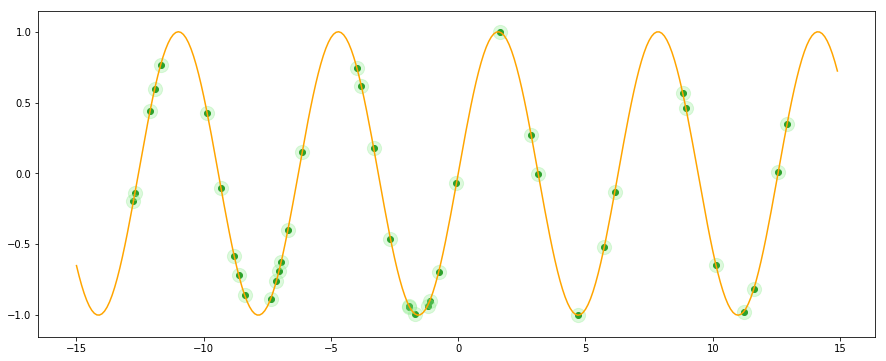

In [21]:
train_xs = np.random.uniform(-13, 13, size=40)
train_ys = np.sin(train_xs)

test_xs = np.arange(-15, 15, 0.1)
test_ys = np.sin(test_xs)

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.scatter(train_xs, train_ys, s=200, color="lightgreen", alpha=0.3)
plt.plot(test_xs, test_ys, color='orange')
plt.show()

<br>

### Vanilla Neural Net

Note that this is pretty amazing that an ANN with so many weights can learn a function with so few points.

Final loss 0.0009040211443789303


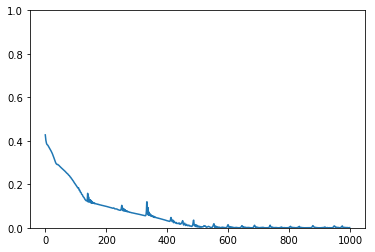

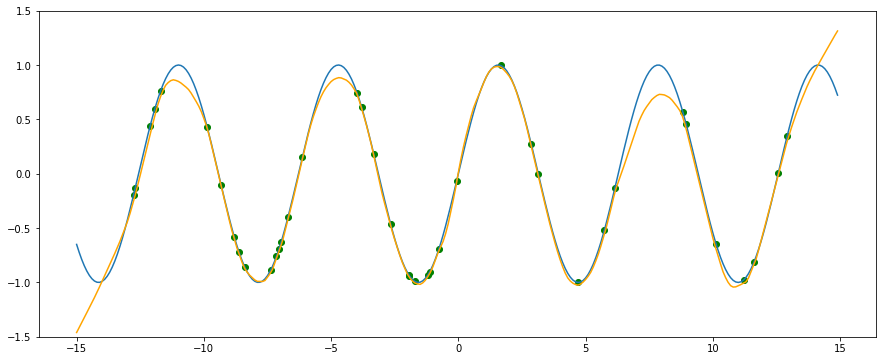

In [68]:
class VanillaFullyConnectedNN(nn.Module):
    def __init__(self, hidden_levels: int, hidden_size: int):
        super().__init__()
        levels = []
        for _ in range(hidden_levels):
            levels.append(nn.Linear(hidden_size, hidden_size))
            levels.append(nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            *levels,
            nn.Linear(hidden_size, 1))
    
    def forward(self, xs):
        return self.fc(xs)

    
def train(model, train_xs, train_ys, epoch_nb: int, lr: float):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ds = data.TensorDataset(torch.FloatTensor(train_xs).unsqueeze(-1),
                            torch.FloatTensor(train_ys).unsqueeze(-1))
    loader = data.DataLoader(ds, batch_size=100, shuffle=True)

    losses = []
    for _ in range(epoch_nb):
        episode_loss = 0.
        for x, y in loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
        losses.append(episode_loss)
    return losses


def predict(model, test_xs):
    model.eval()
    return model(torch.FloatTensor(test_xs).unsqueeze(-1)).detach().numpy()


model = VanillaFullyConnectedNN(hidden_levels=5, hidden_size=256)
losses = train(model, train_xs, train_ys, epoch_nb=1000, lr=2e-4)
ys_pred = predict(model, test_xs)
print('Final loss', losses[-1])
plt.plot(losses)
plt.ylim(0, 1.0)
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, ys_pred, color='orange')
plt.ylim(-1.5, 1.5)
plt.show()

<br>

### Residual Networks

Final loss 0.0012045437470078468


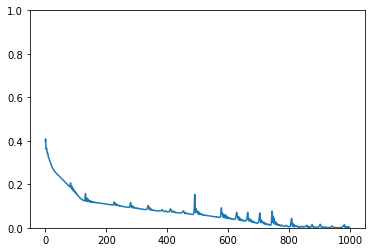

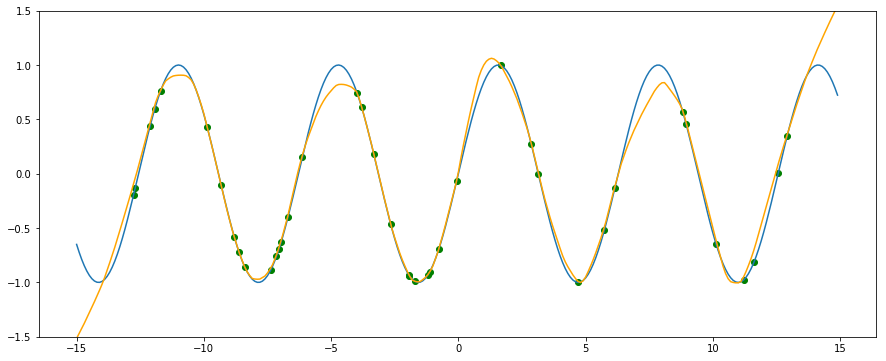

In [93]:
class ResLinearBlock(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        self.shortcut = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, xs):
        ys = self.l1(xs)
        ys = self.relu(ys)
        ys = self.l2(ys)
        xs = self.shortcut(xs)
        return self.relu(xs + ys)


class ResidualNet(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.l1 = ResLinearBlock(hidden_size, hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.l2 = ResLinearBlock(hidden_size, hidden_size, hidden_size)
        self.fcN = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, xs):
        xs = self.relu(self.fc1(xs))
        xs = self.l1(xs)
        xs = self.relu(self.fc2(xs))
        xs = self.l2(xs)
        return self.fcN(xs)
        

model = ResidualNet(hidden_size=256)
losses = train(model, train_xs, train_ys, epoch_nb=1000, lr=2e-4)
ys_pred = predict(model, test_xs)
print('Final loss', losses[-1])
plt.plot(losses)
plt.ylim(0, 1.0)
plt.show()


plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, ys_pred, color='orange')
plt.ylim(-1.5, 1.5)
plt.show()

<br>

### Batch Normalization

Increases the speed of learning tremendously! It even goes to overfitting.

Final loss 0.0007376351859420538


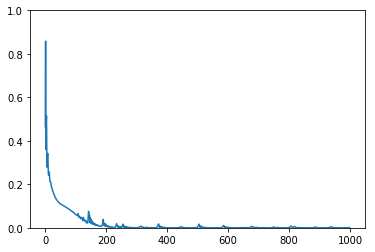

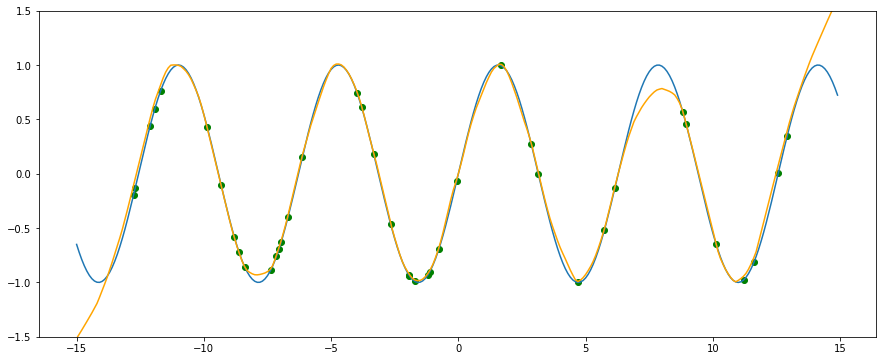

In [120]:
class ResidualNetWithBN(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.l1 = ResLinearBlock(hidden_size, hidden_size, hidden_size)
        self.bn1 = BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.l2 = ResLinearBlock(hidden_size, hidden_size, hidden_size)
        self.bn2 = BatchNorm1d(hidden_size)
        self.fcN = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, xs):
        xs = self.relu(self.fc1(xs))
        xs = self.l1(xs)
        xs = self.bn1(xs)
        xs = self.relu(self.fc2(xs))
        xs = self.l2(xs)
        xs = self.bn2(xs)
        return self.fcN(xs)
        

model = ResidualNetWithBN(hidden_size=256)
losses = train(model, train_xs, train_ys, epoch_nb=1000, lr=2e-4)
ys_pred = predict(model, test_xs)
print('Final loss', losses[-1])
plt.plot(losses)
plt.ylim(0, 1.0)
plt.show()


plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, ys_pred, color='orange')
plt.ylim(-1.5, 1.5)
plt.show()